In [1]:

import os
import time
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
# rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
5446,X,152500000,153000000,0.530530,66.362452,500000
5447,X,153000000,153500000,0.526266,74.503388,500000
5448,X,153500000,154000000,0.513464,75.837731,500000
5449,X,154000000,154500000,0.396106,61.508320,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 200

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in the first 30 bins
cn[:30, :30] = 1

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

In [5]:
num_states = 13

# build the transition matrix using cn
def build_trans_mat(cn, num_states=13):
    num_loci, num_cells = cn.shape
    trans_mat = torch.eye(num_states, num_states) + 1
    for i in range(num_cells):
        for j in range(1, num_loci):
            cur_state = int(cn[j, i])
            prev_state = int(cn[j-1, i])
            trans_mat[prev_state, cur_state] += 1
    return trans_mat

def create_cn_prior(true_cn, weight=1e6, num_states=13):
    num_loci, num_cells = true_cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(true_cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior

cn_prior = create_cn_prior(cn, num_states=num_states)
cn_prior_1 = create_cn_prior(cn, weight=1e9, num_states=num_states)
trans_mat = build_trans_mat(cn, num_states=num_states)

### Define generative model

 Trace Shapes:          
  Param Sites:          
   expose_nb_r         1
 Sample Sites:          
 expose_a dist       1 |
         value       1 |
      log_prob       1 |
num_cells dist         |
         value     170 |
      log_prob         |
 expose_t dist     170 |
         value     170 |
      log_prob     170 |
 expose_u dist     170 |
         value     170 |
      log_prob     170 |
 num_loci dist         |
         value     200 |
      log_prob         |
      rep dist 200 170 |
         value 200 170 |
      log_prob 200 170 |
    reads dist 200 170 |
         value 200 170 |
      log_prob 200 170 |


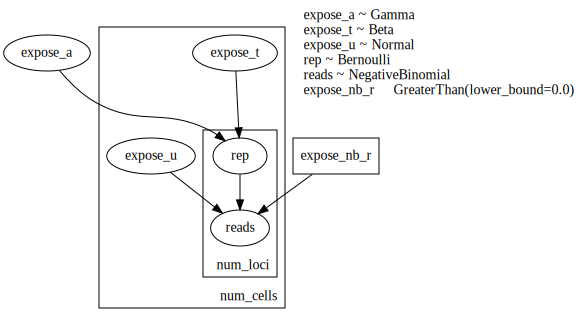

In [6]:

@config_enumerate
def model_S_old(cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, cn_prior=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

trace = poutine.trace(model_S_old).get_trace(cn, rt, num_cells=num_cells)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S_old, model_args=(cn, rt, num_cells), 
                  render_distributions=True, render_params=True)

      Trace Shapes:             
       Param Sites:             
        expose_nb_r         1   
      Sample Sites:             
      expose_a dist       1 |   
              value       1 |   
           log_prob       1 |   
     num_loci0 dist         |   
              value     200 |   
           log_prob         |   
     expose_rt dist     200 |   
              value     200 |   
           log_prob     200 |   
     num_cells dist         |   
              value     170 |   
           log_prob         |   
      expose_t dist     170 |   
              value     170 |   
           log_prob     170 |   
      expose_u dist     170 |   
              value     170 |   
           log_prob     170 |   
      num_loci dist         |   
              value     200 |   
           log_prob         |   
expose_cn_prob dist 200 170 | 13
              value 200 170 | 13
           log_prob 200 170 |   
            cn dist 200 170 |   
              value 200 170 |   
          

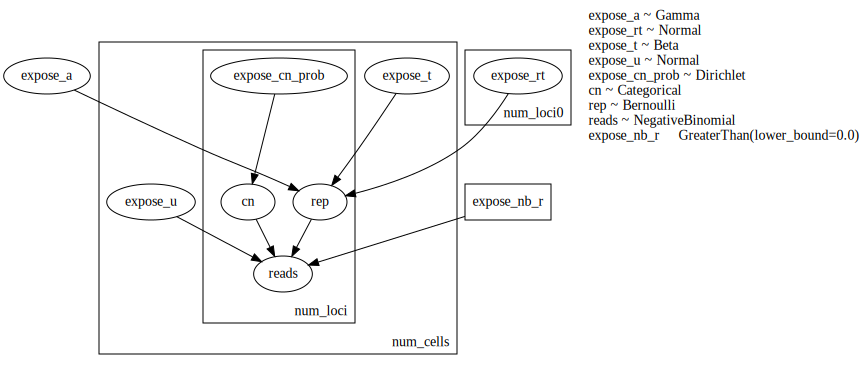

In [7]:
trace = poutine.trace(model_S_old).get_trace(None, num_cells=num_cells, num_loci=num_loci)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S_old, model_args=(None, None, num_cells, num_loci), 
                  render_distributions=True, render_params=True)

In [8]:
@config_enumerate
def model_S1(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_loci, num_cells = args['data'].shape
    elif 'cn0' in args:
        num_loci, num_cells = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn = args['cn0']

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))

        with pyro.plate('num_loci', num_loci):
            
            if 'cn0' not in args:
                if 'cn_prior' not in args:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                else:
                    cn_prior = args['cn_prior']
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if 'data' in args:
                obs = args['data']
            else:
                obs = None
            
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)
    
# TODO: figure out how to render_model later
# args = {'num_cells': num_cells, 'num_loci': num_loci}
# pyro.render_model(model_S, model_args=(args), 
#                   render_distributions=True, render_params=True)

### Simulate and visualize data

In [9]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S1,
    data={
        'expose_a': torch.tensor([10.]),
        'expose_rt': rt
    })

model_trace = pyro.poutine.trace(conditioned_model)

args = {'cn0': cn}

samples = model_trace.get_trace(args)

t = samples.nodes['expose_t']['value']
a = samples.nodes['expose_a']['value']
u = samples.nodes['expose_u']['value']
nb_r = samples.nodes['expose_nb_r']['value']

t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * t_diff))

rep = samples.nodes['rep']['value']

rep_cn = cn * (1. + rep)

reads = samples.nodes['reads']['value']


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


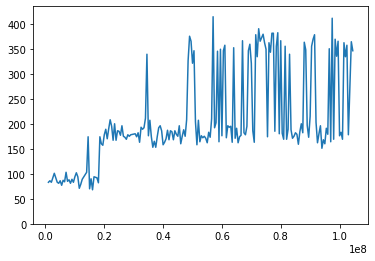

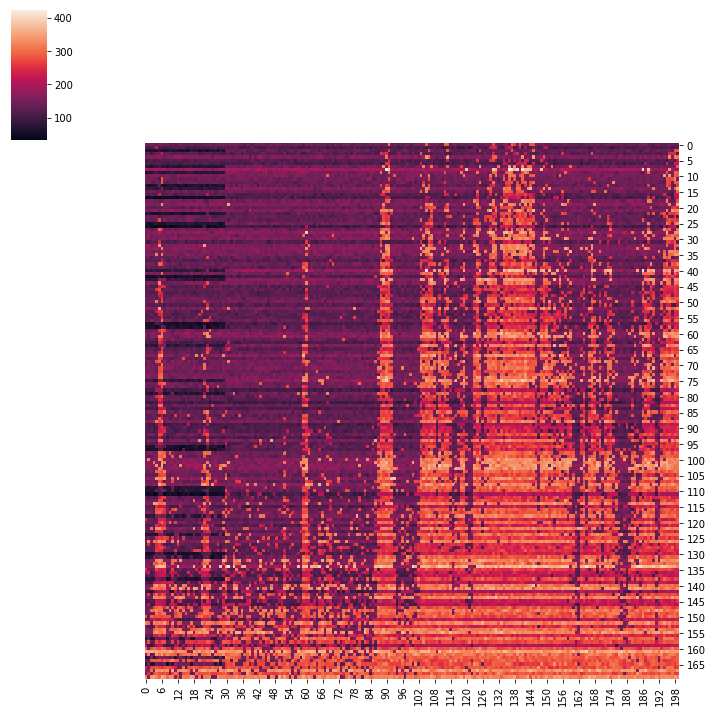

In [10]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)

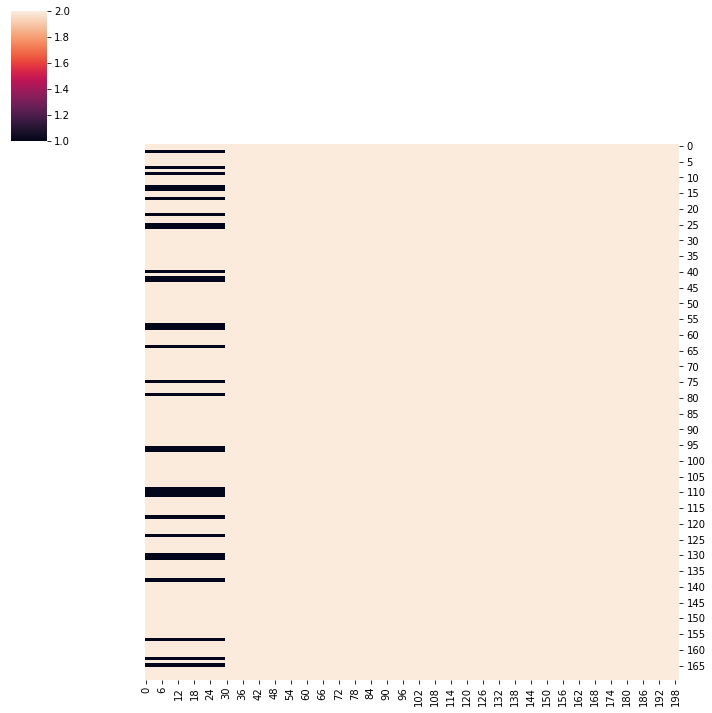

In [11]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

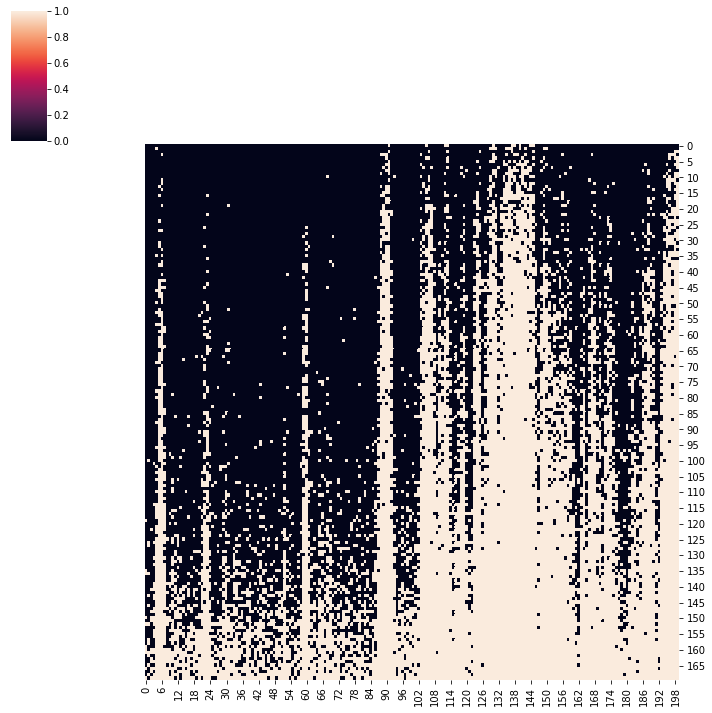

In [12]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


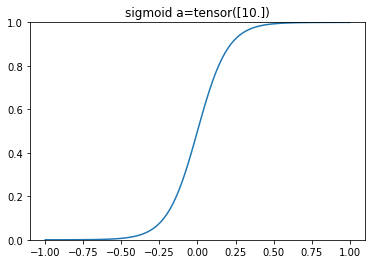

In [13]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['expose_a']['value'].detach())


### Normalize each cell to the same total number of reads

In [14]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

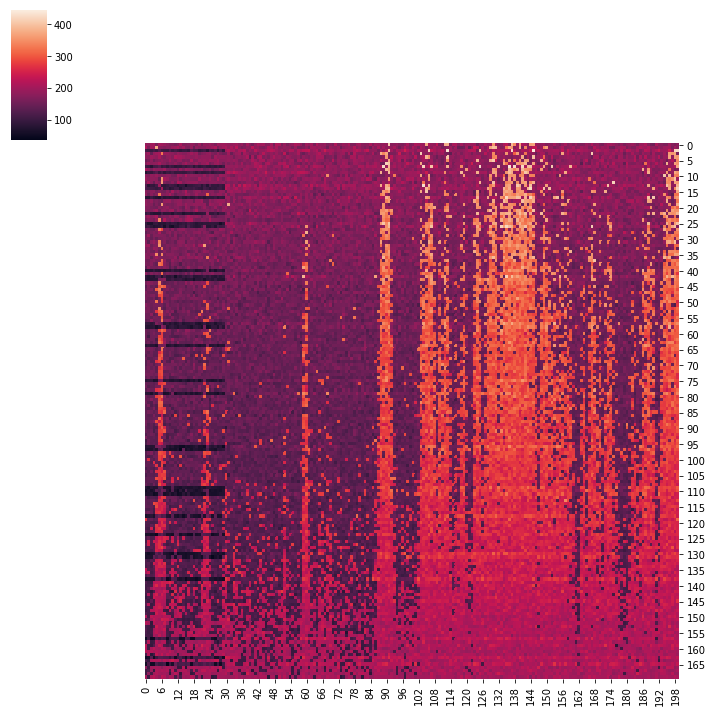

In [15]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)
plt.show()

### Infer all relevant params just taking `reads_norm` as input

In [16]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
rt = rt.type(torch.float32)

In [17]:
def test_model_runtime(model, model_input, max_plate_nesting=2, first_available_dim=-3, 
                       condition_dict={}, num_iter=20, plot_loss=True):
    pyro.clear_param_store()
    
    optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_plate_nesting=max_plate_nesting)
    
    conditioned_model = poutine.condition(
        model,
        data=condition_dict
    )
    
    guide = AutoDelta(
        poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
    )
    svi = SVI(conditioned_model, guide, optim, loss=elbo)
    
    pyro.clear_param_store()
    
    print('running svi')
    losses = []
    iter_times = []
    prev_time = time.time()
    for i in range(num_iter):
        #TODO: make input to svi.step() generalizable
        loss = svi.step(args=model_input)
        cur_time = time.time()
        iter_times.append(cur_time - prev_time)
        prev_time = cur_time
        losses.append(loss)
        print('.', end='')
    
    if plot_loss:
        plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        plt.plot(losses)
        plt.xlabel('iters')
        plt.ylabel('loss')
        plt.title('Convergence of SVI')
        plt.show()
    
    # get trace of discrete params
    guide_trace = poutine.trace(guide).get_trace(args=model_input)
    trained_model = poutine.replay(conditioned_model, trace=guide_trace)

    inferred_model = infer_discrete(
        trained_model, temperature=0,
        first_available_dim=first_available_dim)
    trace = poutine.trace(inferred_model).get_trace(args=model_input)

    return trace, iter_times


def plot_model_heatmaps(trace, t, cn_name='cn', rep_name='rep', model_name='model'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.heatmap(trace.nodes[cn_name]["value"].numpy().astype(float).T[np.argsort(t), :],
               ax=axs[0])
    axs[0].set_title('CN inferred by {}'.format(model_name))
    axs[0].set_ylabel('cells')
    axs[0].set_xlabel('loci')
    sns.heatmap(trace.nodes[rep_name]["value"].numpy().astype(float).T[np.argsort(t), :],
               ax=axs[1])
    axs[1].set_title('Rep inferred by {}'.format(model_name))
    axs[1].set_ylabel('cells')
    axs[1].set_xlabel('loci')
    plt.show()

    
def extract_hmm_trace_output(trace, cn, rep_name='rep', cn_name='cn'):
    model_rep = torch.zeros(cn.shape)
    model_cn = torch.zeros(cn.shape)
    for l in range(cn.shape[0]):
        temp_rep = trace.nodes['{}_{}'.format(rep_name, l)]['value']
        temp_cn = trace.nodes['{}_{}'.format(cn_name, l)]['value']
        model_rep[l] = temp_rep
        model_cn[l] = temp_cn
    return model_cn, model_rep
    

def plot_hmm_model_heatmaps(trace, t, cn, cn_name='cn', rep_name='rep', model_name='model'):
    model_cn, model_rep = extract_hmm_trace_output(trace, cn, rep_name=rep_name, cn_name=cn_name)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.heatmap(model_cn.numpy().astype(float).T[np.argsort(t), :],
               ax=axs[0])
    axs[0].set_title('CN inferred by {}'.format(model_name))
    axs[0].set_ylabel('cells')
    axs[0].set_xlabel('loci')
    sns.heatmap(model_rep.numpy().astype(float).T[np.argsort(t), :],
               ax=axs[1])
    axs[1].set_title('Rep inferred by {}'.format(model_name))
    axs[1].set_ylabel('cells')
    axs[1].set_xlabel('loci')
    plt.show()


def plot_iter_times(iter_times, model_name='model'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.scatterplot(x=range(len(iter_times)), y=iter_times, ax=ax)
    ax.set_xlabel('iter')
    ax.set_ylabel('time (s)')
    ax.set_title('Runtime for {}'.format(model_name))
    plt.show()
    


running svi
....................

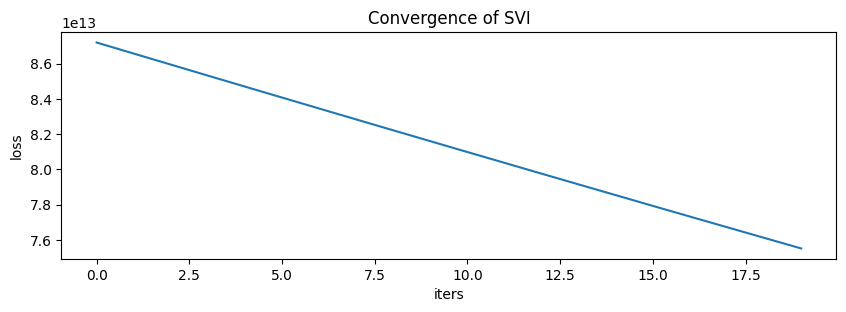

In [18]:
trace, iter_times = test_model_runtime(model_S1, {'data': reads, 'cn_prior': cn_prior_1})

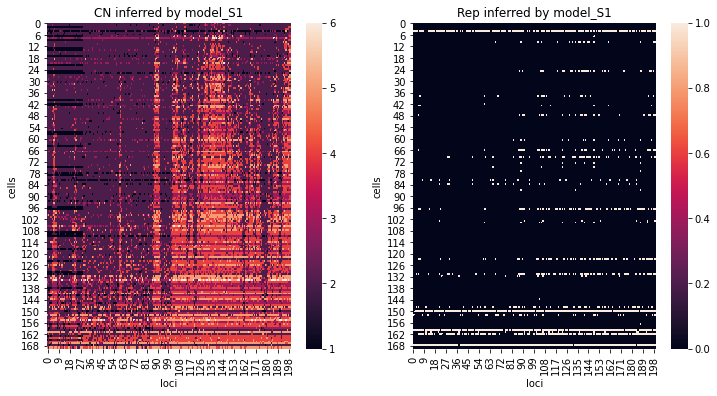

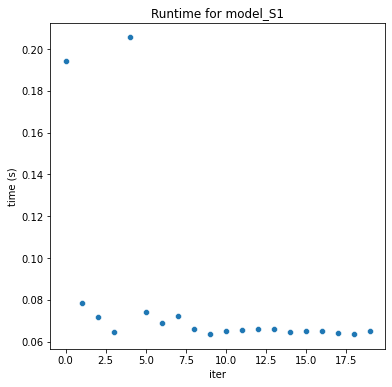

In [19]:
plot_model_heatmaps(trace, t, model_name=model_S1.__name__)
plot_iter_times(iter_times, model_name=model_S1.__name__)

### Now try to infer with a model that has an HMM structure for copy number

In [91]:
@config_enumerate
def model_S2(args):
    assert ('num_cells' in args) or ('data' in args) or ('cn0' in args)

    if 'data' in args:
        num_loci, num_cells = args['data'].shape
    elif 'cn0' in args:
        num_loci, num_cells = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_cells = args['num_cells']


    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn0 = args['cn0']

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
        
        if 'cn0' not in args:
            cn = 2

        for l in pyro.markov(range(num_loci)):
            
            # sample copy number states using HMM structure
            if 'cn0' not in args:
                trans_mat = args['trans_mat']
                cn_prior = args['cn_prior']
                #print('trans_mat', trans_mat.shape)
                #print('cn_prior', cn_prior.shape)
                temp_cn_prob = trans_mat[cn] * cn_prior[l]
                #print('temp_cn_prob', temp_cn_prob.shape)
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]

            # per cell per bin late or early 
            time_diff = t.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if 'data' in args:
                obs = args['data'][l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

# pyro.render_model(model_S2, model_args=(None, None, None, None, reads, cn_prior, trans_mat), 
#                   render_distributions=True, render_params=True)

running svi
....................

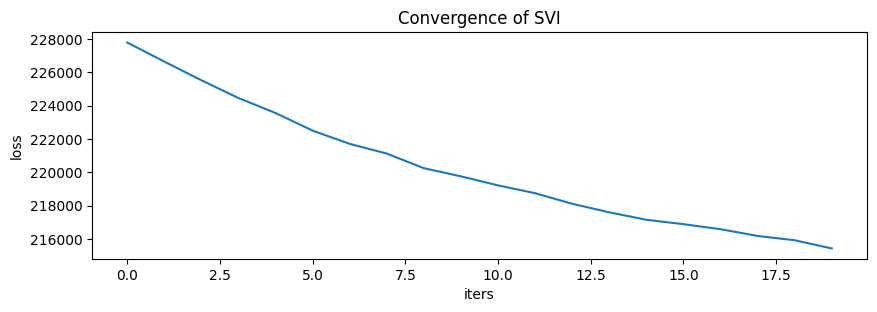

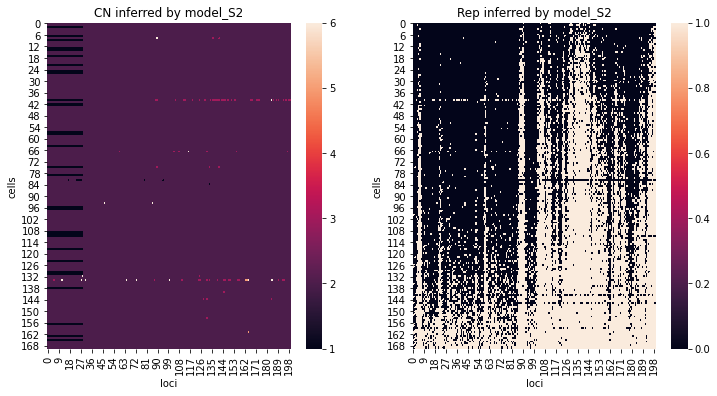

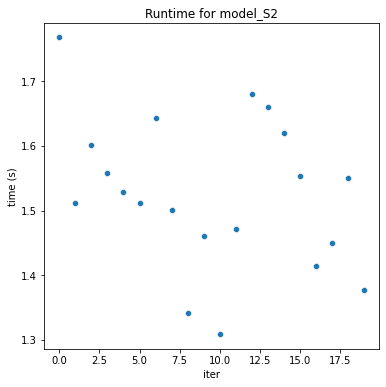

In [92]:
trace, iter_times = test_model_runtime(model_S2, {'data': reads, 'cn_prior': cn_prior, 'trans_mat': trans_mat})
plot_hmm_model_heatmaps(trace, t, cn, model_name=model_S2.__name__)
plot_iter_times(iter_times, model_name=model_S2.__name__)

running svi
....................

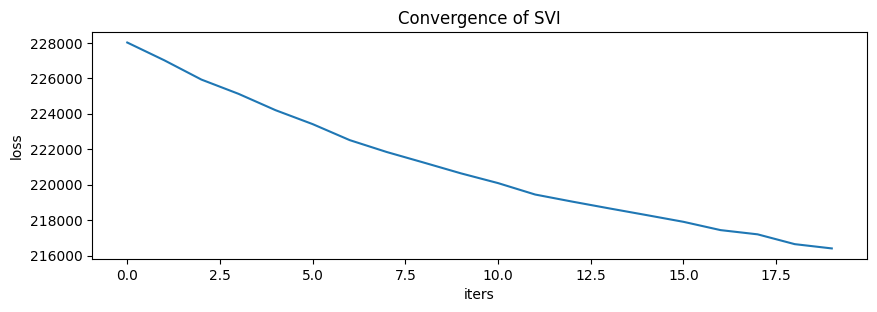

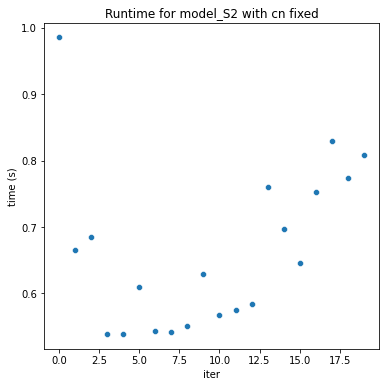

In [22]:
# see what the hmm model looks like when cn is fixed
name = 'model_S2 with cn fixed'
trace, iter_times = test_model_runtime(model_S2, {'data': reads, 'cn0': cn})
# plot_hmm_model_heatmaps(trace, t, cn, model_name=name)
plot_iter_times(iter_times, model_name=name)

### Treat each chromosome as a unique sequence to help speed up parallelization

Create `lengths`, new `data`

In [23]:
rtdata

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt
0,1,1000000,1500000,0.598330,81.441980,500000,0.987191
1,1,1500000,2000000,0.539496,79.131013,500000,0.955007
2,1,2000000,2500000,0.594508,78.557313,500000,0.947017
3,1,3000000,3500000,0.584570,70.388076,500000,0.833248
4,1,4000000,4500000,0.482572,48.663092,500000,0.530694
...,...,...,...,...,...,...,...
5446,X,152500000,153000000,0.530530,66.362452,500000,0.777185
5447,X,153000000,153500000,0.526266,74.503388,500000,0.890560
5448,X,153500000,154000000,0.513464,75.837731,500000,0.909143
5449,X,154000000,154500000,0.396106,61.508320,500000,0.709583


In [93]:
rtdata_subset = rtdata.loc[rtdata['chr'].isin(['1', '20', '21', '22'])]
rtdata_subset.chr.unique()

array(['1', '20', '21', '22'], dtype=object)

In [94]:
lengths = []
chrom_ids = set()
for i in range(num_cells):
    for chrom, group in rtdata_subset.groupby('chr'):
        lengths.append(group.shape[0])
lengths = torch.tensor(lengths)
lengths.shape

torch.Size([680])

In [95]:
chrom_lengths = []
for chrom, group in rtdata_subset.groupby('chr'):
    chrom_lengths.append(group.shape[0])
chrom_lengths = torch.tensor(chrom_lengths)
chrom_lengths

tensor([428, 114,  61,  65])

In [27]:
cn3 = torch.ones(max(lengths), len(lengths)) * 2
cn3.shape

torch.Size([114, 510])

In [28]:
rt3 = torch.tensor(rtdata_subset['norm_mcf7rt'].values)

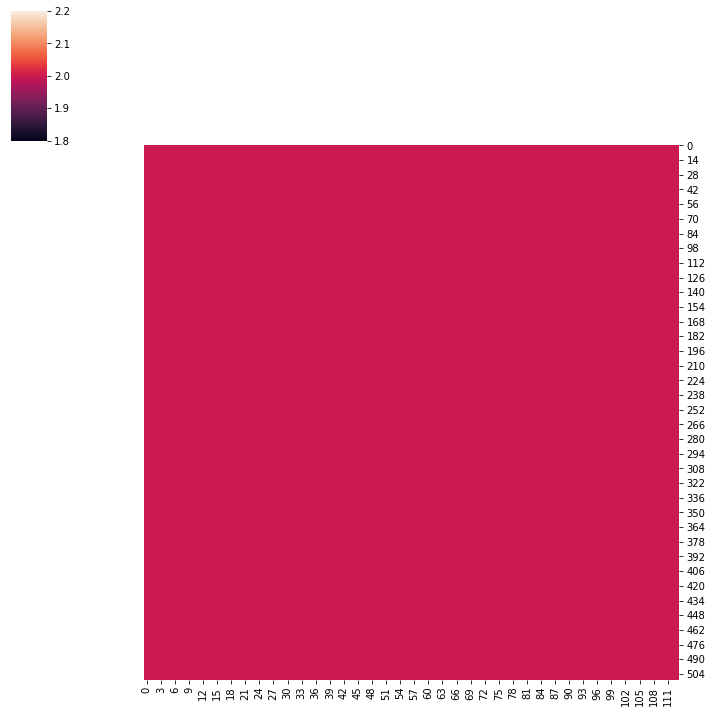

In [29]:
# visualize the true copy number heatmap
sns.clustermap(cn3.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

In [86]:
@config_enumerate
def model_S3(args):
    assert ('lengths' in args) and ('chrom_lengths' in args) and ('num_cells' in args)

    if 'data' in args:
        max_length, num_sequences = args['data'].shape
    elif 'cn0' in args:
        max_length, num_sequences = args['cn0'].shape
    else:
        num_loci = args['num_loci']
        num_sequences = args['num_sequences']
    
    num_cells = args['num_cells']
    chrom_lengths = args['chrom_lengths']
    num_chroms = len(chrom_lengths)
    num_loci = chrom_lengths.sum()
    lengths = args['lengths']
    
    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    assert num_chroms * num_cells == num_sequences

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
        
    # use rt0 as an informed prior if provided
    if 'rt0' in args:
        with pyro.plate('num_loci', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(args['rt0'], 0.1))
    else:
        with pyro.plate('num_loci', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # draw u and t at the cell-level
    with pyro.plate('num_cells', num_cells):
        # per cell replication time
        t = pyro.sample('expose_t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))
        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
    
    # fix cn as constant when input into model
    if 'cn0' in args:
        cn0 = args['cn0']
        
    #subsample_size = num_sequences
    with pyro.plate('num_sequences', num_sequences) as b:
        
        #print('b', b)

        # find t and u from the cell that matches this sequence
        cell_idx = torch.floor(b / num_chroms).type(torch.long)
        #print('cell_idx', cell_idx)
        #print('t', t.shape)
        #print('u', u.shape)
        temp_t = t[cell_idx]
        temp_u = u[cell_idx]
        
        # find rt from the chromsome that matches this sequence
        chrom = torch.remainder(b, num_chroms).type(torch.long)
        #print('chrom', chrom)
        left_loci_idx = torch.zeros(chrom.shape)
        for i, c in enumerate(chrom):
            left_loci_idx[i] = chrom_lengths[:c].sum()
        #left_loci_idx = torch.take(chrom_lengths, chrom).sum()
        #print('left', left_loci_idx)
        #left_loci_idx = chrom_lengths[:chrom.unsqueeze(-1)].sum()
        right_loci_idx = left_loci_idx + chrom_lengths[chrom]
        #print('right', right_loci_idx)
        temp_rt = torch.zeros(max_length, num_sequences)
        for i in range(num_sequences):
            #print('i {}, left {}, right {}'.format(i, left_loci_idx[i], right_loci_idx[i]))
            rt_slice = rt[left_loci_idx[i].type(torch.int) : right_loci_idx[i].type(torch.int)]
            #print('rt_slice', rt_slice.shape)
            #print('rt', rt.shape)
            temp_rt[0:len(rt_slice), i] = rt_slice
        #print('temp_rt', temp_rt)
        
        if 'cn0' not in args:
            cn = 2

        for l in pyro.markov(range(max_length)):
            #with poutine.mask(mask=(l < lengths).unsqueeze(-1)):
            
            # sample copy number states using HMM structure
            if 'cn0' not in args:
                trans_mat = args['trans_mat']
                cn_prior = args['cn_prior']
                # print('trans_mat', trans_mat.shape)
                # print('cn_prior', cn_prior.shape)
                temp_cn_prob = trans_mat[cn] # * cn_prior[l, b]
                # print('temp_cn_prob', temp_cn_prob.shape)
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l, b]

            # per cell per bin late or early
            time_diff = temp_t.reshape(-1, num_sequences) - temp_rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (temp_u * rep_cn)
            # print('cn', cn.shape)
            # print('temp_u', temp_u.shape)
            # print('expected_reads', expected_reads.shape)

            nb_p = expected_reads / (expected_reads + nb_r)

            # print('nb_r', nb_r.shape)
            # print('nb_p', nb_p.shape)

            if 'data' in args:
                obs = args['data'][l, b]
                # print('obs', obs.shape)
            else:
                obs = None

            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [87]:
## simulate data using this chr-specific model
pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S3,
    data={
        'expose_a': torch.tensor([10.]),
        'expose_rt': rt3
    })

model_trace = pyro.poutine.trace(conditioned_model)

args = {'cn0': cn3, 'lengths': lengths, 'chrom_lengths': chrom_lengths, 'num_cells': num_cells}

samples = model_trace.get_trace(args)

t3 = samples.nodes['expose_t']['value']
a3 = samples.nodes['expose_a']['value']
u3 = samples.nodes['expose_u']['value']
nb_r3 = samples.nodes['expose_nb_r']['value']

t_diff3 = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep3 = 1 / (1 + torch.exp(-a * t_diff))

def extract_model3_sim_output(trace, cn, rep_name='rep', reads_name='reads'):
    model_rep = torch.zeros(cn.shape)
    model_reads = torch.zeros(cn.shape)
    for l in range(cn.shape[0]):
        temp_rep = trace.nodes['{}_{}'.format(rep_name, l)]['value']
        temp_reads = trace.nodes['{}_{}'.format(reads_name, l)]['value']
        #print(temp_rep.shape)
        model_rep[l] = temp_rep
        model_reads[l] = temp_reads
    return model_rep, model_reads

rep3, reads3 = extract_model3_sim_output(samples, cn3)


In [88]:
cn_prior3 = create_cn_prior(cn3, num_states=num_states)

running svi
....................

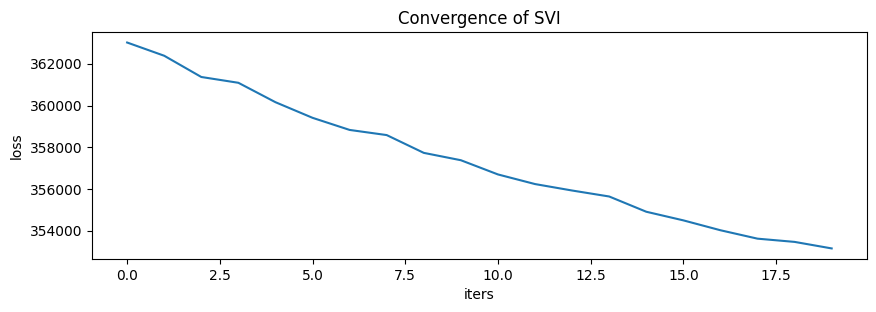

In [89]:
trace, iter_times = test_model_runtime(model_S3, {'data': reads3, 'trans_mat': trans_mat,
                                                  'lengths': lengths, 'chrom_lengths': chrom_lengths,
                                                  'num_cells': num_cells, 'cn_prior': cn_prior3
                                                 })

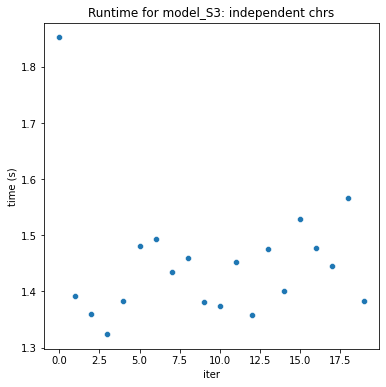

In [90]:
name = 'model_S3: independent chrs'
plot_iter_times(iter_times, model_name=name)